# Example: CEST

In [1]:
# git clone https://github.com/alsinmr/pyRelaxSim.git
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Build the spin-system 

In [3]:
ex=RS.ExpSys(v0H=600,Nucs='13C',T_K=298)
ex.set_inter(Type='CS',i=0,ppm=-10)
ex1=ex.copy()
ex1.set_inter(Type='CS',i=0,ppm=10)

## Calculate the Liouvillian with exchange, add T1, T2 relaxation

In [5]:
kex=np.array([[-1e1,1e3],[1e1,-1e3]])
L=RS.Liouvillian((ex,ex1),kex=kex)
L.add_relax(Type='T1',i=0,T1=1.5)
L.add_relax(Type='T2',i=0,T2=.1)
L.add_relax(Type='recovery')
d,v=np.linalg.eig(kex)
pop=v[:,np.argmin(np.abs(d))]
pop/=pop.sum()
print(f'Normalized populations are {pop}')

Normalized populations are [0.99009901 0.00990099]


## Saturation propagators (sweep $\nu_{off}$), Upi/2, Uprop

In [6]:
U=list()
voff0=np.linspace(-3000,3000,200)
for voff in voff0:
    L.fields[0]=(200,0,voff)
    U.append(L.U(Dt=.2))
    
L.fields[0]=(100000,np.pi/2,0)
Upi2=L.U(t0=0,Dt=2.5e-6)
L.fields[0]=(0,0,0)
Uprop=L.U(t0=0,Dt=1/6000)


## Prepare and propagate the system at each offset

In [7]:
rho=RS.Rho(rho0='13Cz',detect='13Cp',L=L)
I=list()
for U0 in U:
    rho.clear()
    Upi2*U0*rho
    rho.DetProp(Uprop,n=1024)
    I.append(rho.FT[0].real)
    

## Plot a few of the spectra

<IPython.core.display.Javascript object>


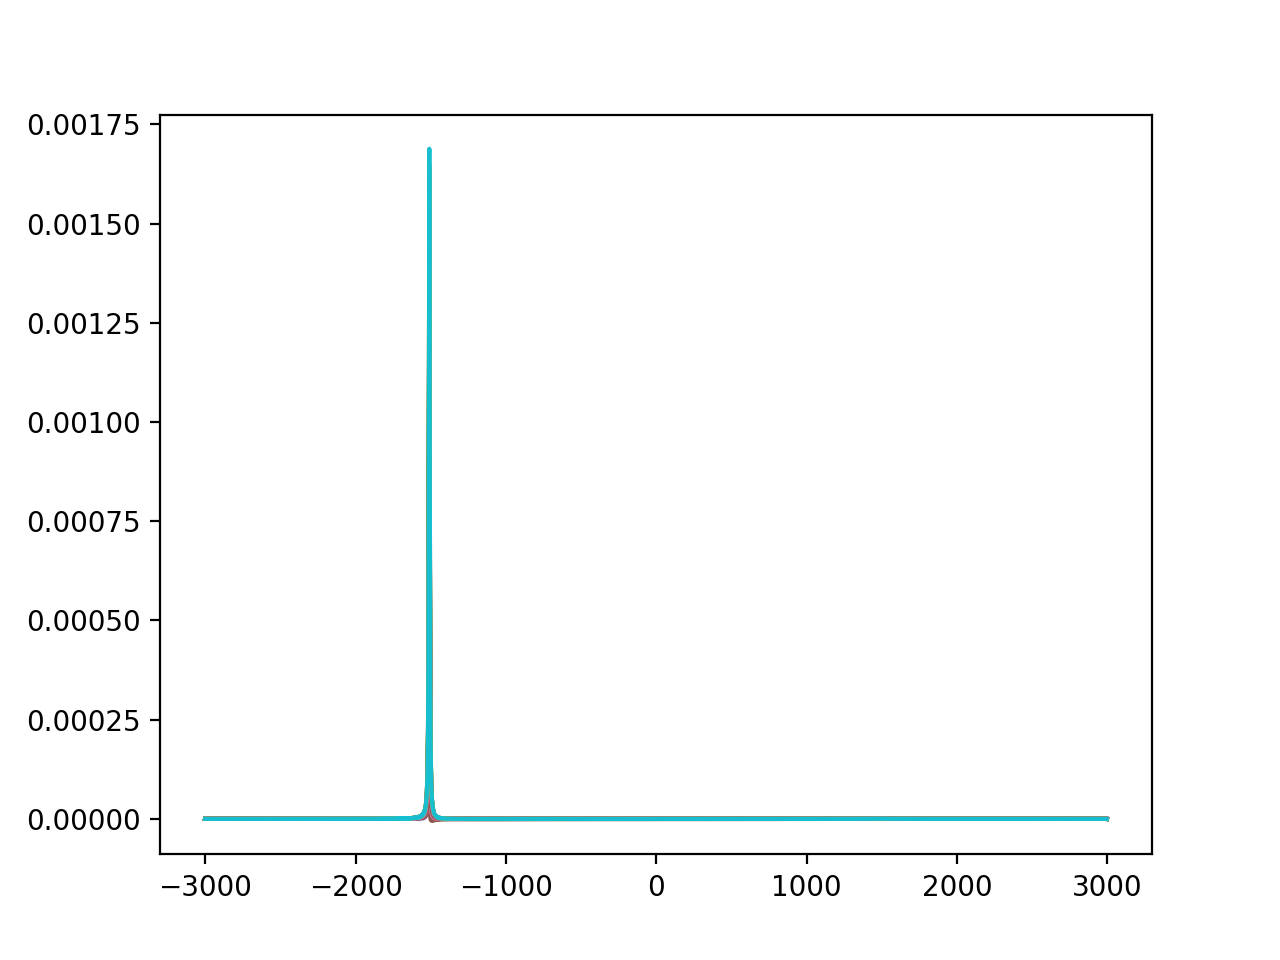

In [8]:
ax=plt.figure().add_subplot(111)
for I0 in I[::10]:
    ax.plot(rho.v_axis,I0)

In [9]:
S=np.array([I0.sum() for I0 in I])

<IPython.core.display.Javascript object>


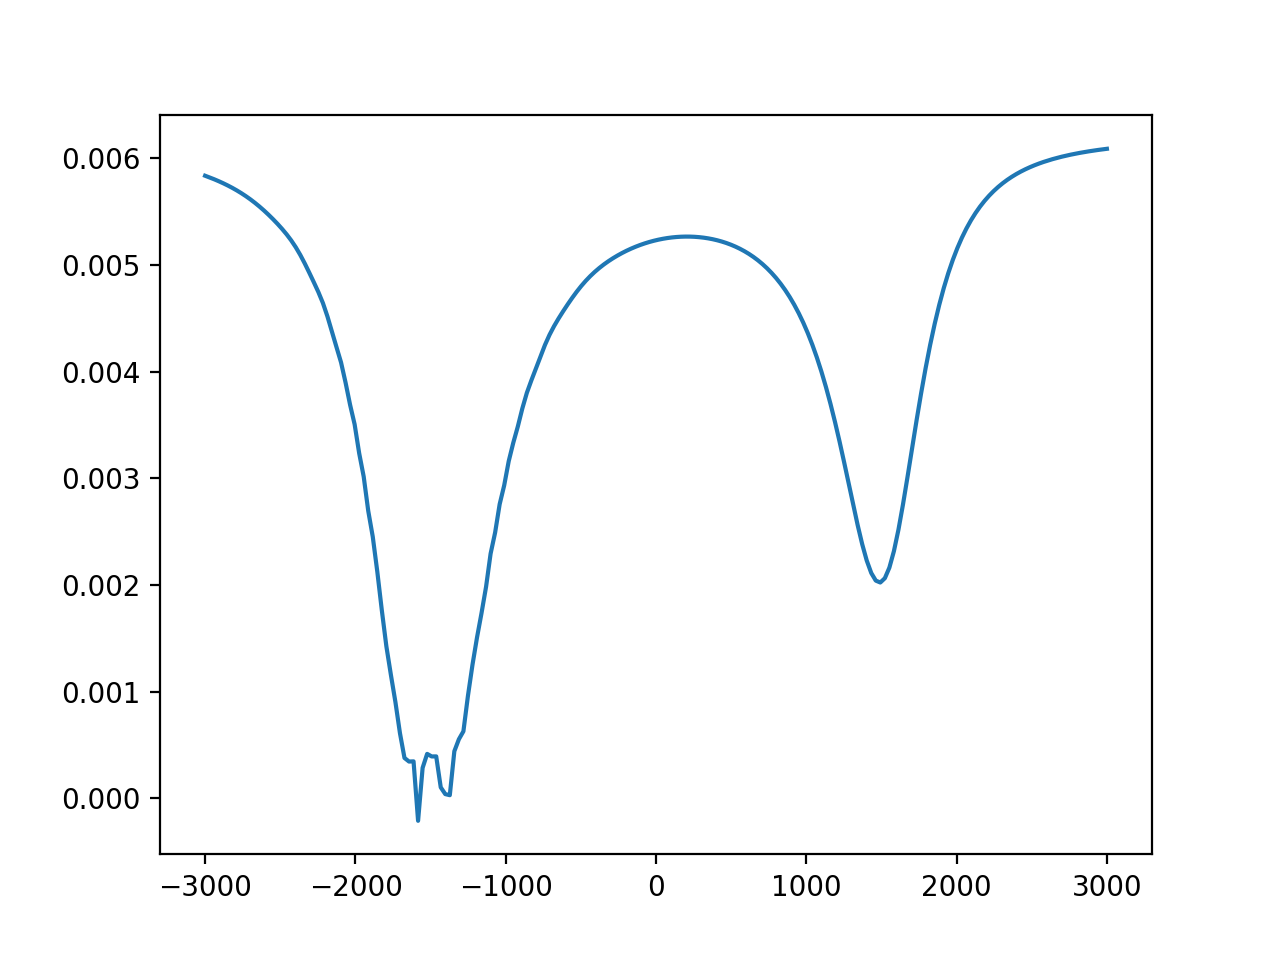

In [10]:
ax=plt.figure().add_subplot(111)
ax.plot(voff0,S)